### Sistema Fully Coupled (Girsanov)
$$
\begin{cases}
dS_t =\mu_1(c_1-S_t)dt + \sigma_1dW^1_t\\
dH_t = \mu_2(c_2-H_t)dt + \sigma_2 dW^2_t\\
dV_t = b_V(A_t)dt +\sigma_3 dW^3_t\\
dX_t = V_t dt
\end{cases}
$$
where
$$
b_V(A)=f(A)\Psi(X) + (c_3\Psi(-X)-c_4\Psi(X-10))\Psi(5(V+1))
$$
with
$$\Psi(x)=\max(0,\min(1,x/d,(x_{max}-x)/d))$$ and $f$ a function that we will later choose with care, for now $f=0$$.

### Soluzione
$$
    u(t,s,h,v,x) = -\gamma e^s x 
$$

### Equazione backward
$$
 dY_t = -\gamma e^{S_t}\left( X_t \mu_1(c_1-S_t)+V_t +0.5\sigma_1^2X_t \right)dt + Z_t dW_t,
$$
where in the final solution $Z_t = (-\gamma e^{S_t}X_t\sigma_1,0,0,0)$.


### Secondo Modello
Qui si fissa $f(A)=-0.5 V \Psi(X)$ e con $X=-\frac{Z^S e^{-S_t}}{\gamma\sigma_1}$ (che viene sostituito solo dentro $f$)
### Terzo Modello
La $X$ viene sostituita come sopra anche nel drift backward

In [7]:
## Rete neurale con normalizzazione della loss

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from abc import ABC, abstractmethod


class FBSNN(ABC): # Forward-Backward Stochastic Neural Network
    def __init__(self, Xi_generator, T,
                       M, N, D,
                       layers,
                       clip_grad_norm=1.0, 
                       use_antithetic_sampling=True):
        self.Xi_generator = Xi_generator #initial data generator
        self.T = T # terminal time

        self.M = M # number of trajectories
        self.N = N # number of time snapshots
        self.D = D # number of dimensions

        # layers
        self.layers = layers # (D+1) --> 1

        # migliorie advanced richieste
        self.clip_grad_norm = clip_grad_norm
        self.use_antithetic_sampling = bool(use_antithetic_sampling)

        # initialize NN
        self.weights, self.biases = self.initialize_NN(layers)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # tf placeholders and graph (training)
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.t_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, 1]) # M x (N+1) x 1
        self.W_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, self.D]) # M x (N+1) x D
        self.Xi_tf = tf.placeholder(tf.float32, shape=[M, D]) # M x D
        self.const_tf = tf.placeholder(tf.float32, shape=[])

        self.loss, self.X_pred, self.Y_pred, self.Z_pred = self.loss_function(self.t_tf, self.W_tf, self.Xi_tf)

        # optimizer + gradient clipping
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        gradients_and_variables = self.optimizer.compute_gradients(self.loss)
        if self.clip_grad_norm is not None:
            non_null_grads_and_vars = [(g, v) for g, v in gradients_and_variables if g is not None]
            if non_null_grads_and_vars:
                gradients, variables = zip(*non_null_grads_and_vars)
                gradients, _ = tf.clip_by_global_norm(gradients, self.clip_grad_norm)
                clipped = list(zip(gradients, variables))
                untouched = [(g, v) for g, v in gradients_and_variables if g is None]
                gradients_and_variables = clipped + untouched
        self.train_op = self.optimizer.apply_gradients(gradients_and_variables)

        # initialize session and variables
        init = tf.global_variables_initializer()
        self.sess.run(init)
        # Saver for saving/restoring variables
        self.saver = tf.train.Saver()

        # lightweight in-memory checkpoint utilities for early stopping
        self._trainable_vars = tf.trainable_variables()
        self._snapshot_ph = [
            tf.placeholder(tf.float32, shape=v.shape, name=f"snapshot_ph_{i}")
            for i, v in enumerate(self._trainable_vars)
        ]
        self._restore_ops = [v.assign(ph) for v, ph in zip(self._trainable_vars, self._snapshot_ph)]
    
    def save_model(self, path):
        """
        Save the trained model weights to disk.
        """
        save_path = self.saver.save(self.sess, path)
        print(f"Model saved in path: {save_path}")

    def load_model(self, path):
        """
        Restore model weights from disk.
        """
        self.saver.restore(self.sess, path)
        print(f"Model restored from path: {path}")
        
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, t, X): # M x 1, M x D
        u = self.neural_net(tf.concat([t, X], 1), self.weights, self.biases) # M x 1
        Du = tf.gradients(u, X)[0] # M x D
        return u, Du

    def Dg_tf(self, X): # M x D
        return tf.gradients(self.g_tf(X), X)[0] # M x D

    def loss_function(self, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, 1 x D
        loss = 0
        X_list = []
        Y_list = []
        Z_list = []

        t0 = t[:, 0, :]
        W0 = W[:, 0, :]
        #X0 = tf.tile(Xi, [self.M, 1]) # M x D
        X0 = Xi  # già M x D
        Y0, Du0 = self.net_u(t0, X0) # M x 1, M x D
        sigma0 = self.sigma_tf(t0, X0, Y0)
        Z0 = tf.squeeze(tf.matmul(tf.expand_dims(Du0, 1), sigma0), axis=1)

        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)

        for n in range(0, self.N):
            t1 = t[:, n + 1, :]
            W1 = W[:, n + 1, :]

            dW = W1 - W0
            sigma_dW = tf.squeeze(tf.matmul(sigma0, tf.expand_dims(dW, -1)), axis=[-1])
            X1 = X0 + self.mu_tf(t0, X0, Y0, Z0) * (t1 - t0) + sigma_dW

            # Z = Du*sigma e nella backward compare Z*dW.
            Y1_tilde = Y0 + self.phi_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.reduce_sum(Z0 * dW, axis=1, keepdims=True)

            Y1, Du1 = self.net_u(t1, X1)
            sigma1 = self.sigma_tf(t1, X1, Y1)
            Z1 = tf.squeeze(tf.matmul(tf.expand_dims(Du1, 1), sigma1), axis=1)

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            sigma0 = sigma1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)

        loss += tf.reduce_sum(tf.square(Y1 - self.g_tf(X1)))

        Dg = self.Dg_tf(X1)
        Z_terminal = tf.squeeze(tf.matmul(tf.expand_dims(Dg, 1), sigma1), axis=1)
        loss += tf.reduce_sum(tf.square(Z1 - Z_terminal))

        X = tf.stack(X_list, axis=1)
        Y = tf.stack(Y_list, axis=1)
        Z = tf.stack(Z_list, axis=1)

        return loss/self.N, X, Y, Z

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M, N + 1, 1)) # M x (N+1) x 1
        DW = np.zeros((M, N + 1, D)) # M x (N+1) x D

        dt = T / N

        Dt[:, 1:, :] = dt
        if self.use_antithetic_sampling and M > 1:
            half_M = M // 2
            DW_half = np.sqrt(dt) * np.random.normal(size=(half_M, N, D))
            DW[:half_M, 1:, :] = DW_half
            DW[half_M:2 * half_M, 1:, :] = -DW_half
            if M % 2 == 1:
                DW[-1, 1:, :] = np.sqrt(dt) * np.random.normal(size=(N, D))
        else:
            DW[:, 1:, :] = np.sqrt(dt) * np.random.normal(size=(M, N, D))

        t = np.cumsum(Dt, axis=1) # M x (N+1) x 1
        W = np.cumsum(DW, axis=1) # M x (N+1) x D

        Xi_batch = self.Xi_generator(M, D).astype(np.float32)

        return t, W, Xi_batch

    def _get_snapshot(self):
        return self.sess.run(self._trainable_vars)

    def _restore_snapshot(self, weights):
        feed = {ph: w for ph, w in zip(self._snapshot_ph, weights)}
        self.sess.run(self._restore_ops, feed_dict=feed)

    def train(
        self,
        N_Iter,
        learning_rate,
        const_value=None,
        eval_every=50,
        val_batches=8,
        early_stopping_metric='loss',
        #y0_target=None,
        patience=None,
        min_delta=1e-3,
        restore_best=False,
    ):
        start_time = time.time()
        last_loss = None
        #last_y0 = None

        current_const = np.float32(self.const if const_value is None else const_value)

        best_score = np.inf
        best_iter = -1
        best_snapshot = None
        no_improve_iters = 0
        stopped_early = False

        for it in range(N_Iter):
            t_batch, W_batch, Xi_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D, M x D

            tf_dict = {
                self.Xi_tf: Xi_batch,
                self.t_tf: t_batch,
                self.W_tf: W_batch,
                self.learning_rate: learning_rate,
                self.const_tf: current_const,
            }

            self.sess.run(self.train_op, tf_dict)

            if it % 50 == 0:
                elapsed = time.time() - start_time
                elapsed = time.time() - start_time
                loss_value, Y_value, learning_rate_value = self.sess.run([self.loss, self.Y_pred, self.learning_rate], tf_dict)
                last_loss = float(loss_value)
                mean_Y0 = np.mean(Y_value[:, 0, 0])
                print('It: %d, Loss: %.3e, Mean Y0: %.3f, Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, mean_Y0, elapsed, learning_rate_value))
                start_time = time.time()

            if (it % eval_every == 0) or (it == N_Iter - 1):
                eval_stats = self.evaluate(const_value=current_const, n_batches=val_batches)

                #if early_stopping_metric == 'y0_abs':
                #    if y0_target is None:
                #        raise ValueError("y0_target is required when early_stopping_metric='y0_abs'")
                #    score = abs(eval_stats['mean_y0'] - float(y0_target))
                if early_stopping_metric == 'loss':
                    score = eval_stats['mean_loss']

                if (best_score - score) > min_delta:
                    best_score = float(score)
                    best_iter = int(it)
                    best_snapshot = self._get_snapshot()
                    no_improve_iters = 0
                else:
                    no_improve_iters += eval_every

                if patience is not None and no_improve_iters >= patience:
                    print(f"[EarlyStop] it={it}, best_it={best_iter}, best_score={best_score:.6e}")
                    stopped_early = True
                    break

        if restore_best and best_snapshot is not None:
            self._restore_snapshot(best_snapshot)
            print(f"[RestoreBest] best_it={best_iter}, best_score={best_score:.6e}")

        return {
            'const': float(current_const),
            'learning_rate': float(learning_rate),
            'n_iter': int(N_Iter),
            'last_loss': last_loss,
            'best_iter': int(best_iter),
            'best_score': float(best_score),
            'stopped_early': bool(stopped_early),
        }

    def evaluate(self, const_value=None, n_batches=5):
        current_const = np.float32(self.const if const_value is None else const_value)
        losses = []
        y0s = []

        for _ in range(n_batches):
            t_batch, W_batch, Xi_batch = self.fetch_minibatch()
            tf_dict = {
                self.Xi_tf: Xi_batch,
                self.t_tf: t_batch,
                self.W_tf: W_batch,
                self.const_tf: current_const,
            }
            loss_value, y_value = self.sess.run([self.loss, self.Y_pred], tf_dict)
            losses.append(float(loss_value))
            y0s.append(list(y_value[:,0,0]))

        return {
            'const': float(current_const),
            'mean_loss': float(np.mean(losses)),
            'std_loss': float(np.std(losses)),
            'mean_y0': float(np.mean(y0s)),
            'std_y0': float(np.std(y0s)),
            'n_batches': int(n_batches),
        }

    def predict(self, Xi_star, t_star, W_star, const_value=None):
        current_const = np.float32(self.const if const_value is None else const_value)
        tf_dict = {
            self.Xi_tf: Xi_star,
            self.t_tf: t_star,
            self.W_tf: W_star,
            self.const_tf: current_const,
        }

        X_star = self.sess.run(self.X_pred, tf_dict)
        Y_star = self.sess.run(self.Y_pred, tf_dict)
        Z_star = self.sess.run(self.Z_pred, tf_dict)

        return X_star, Y_star, Z_star

    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        pass # M x1

    @abstractmethod
    def g_tf(self, X): # M x D
        pass # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M, D]) # M x D

    @abstractmethod
    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M, D])) # M x D x D
    ###########################################################################


# backward compatibility
fbsde_NN = FBSNN


In [8]:
class NN_Quadratic_Coupled(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, parameters):
        self.mu1 = parameters['mu1']
        self.mu2 = parameters['mu2']
        self.c1 = parameters['c1']
        self.c2 = parameters['c2']
        self.c3 = parameters['c3']
        self.c4 = parameters['c4']
        self.gamma = parameters['gamma']
        self.s1 = parameters['s1']
        self.s2 = parameters['s2']
        self.s3 = parameters['s3']
        self.x_max = parameters['x_max']
        self.v_min = parameters['v_min']
        self.v_max = parameters['v_max']
        self.d = parameters['d']
        self.const = parameters['const']
        super().__init__(Xi, T, M, N, D, layers)

    def psi(self,X_state):
        #S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        result = tf.maximum(0.0,
                   tf.minimum(
                     1.0,
                     tf.minimum(X_state/self.d, (self.x_max - X_state)/self.d)
                     )
                 )
        return result

    def psi3(self,V):
        #S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        result = tf.maximum(0.0,
                   tf.minimum(
                     1.0,
                     (self.v_max- V)/self.d
                     )
                 )
        return result
    
    def psi4(self,V):
        #S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        result = tf.maximum(0.0,
                   tf.minimum(
                     1.0,
                     (V - self.v_min)/self.d
                     )
                 )
        return result

    def f(self,X,Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        Z_S, Z_H, Z_V, _ = tf.split(Z, num_or_size_splits=4, axis=1)
        s1 = tf.cast(self.s1, tf.float32)
        gamma = tf.cast(self.gamma, tf.float32)
        exp_S = tf.exp(-S)
        return -0.5 * V * self.psi(- exp_S * Z_S /(gamma * s1))
    
    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        mu1 = tf.cast(self.mu1, tf.float32)
        mu2 = tf.cast(self.mu2, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        c2 = tf.cast(self.c2, tf.float32)
        c3 = tf.cast(self.c3, tf.float32)
        c4 = tf.cast(self.c4, tf.float32)
        x_max = tf.cast(self.x_max, tf.float32)
        const = tf.cast(self.const_tf, tf.float32)
        dS = mu1 * (c1 - S)
        dH = mu2 * (c2 - H)
        dV = self.f(X,Z) * self.psi(X_state) + c3 * self.psi(-X_state)*self.psi3(V) - c4 * self.psi(X_state-x_max)*self.psi4(V)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)

    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        gamma = tf.cast(self.gamma, tf.float32)
        exp_S = tf.exp(S)
        return -gamma * exp_S * X_state + V**2 + V*X_state

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        Z_S, Z_H, Z_V, _ = tf.split(Z, num_or_size_splits=4, axis=1)
        
        mu1 = tf.cast(self.mu1, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        s1 = tf.cast(self.s1, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)
        c3 = tf.cast(self.c3, tf.float32)
        c4 = tf.cast(self.c4, tf.float32)
        x_max = tf.cast(self.x_max, tf.float32)
        gamma = tf.cast(self.gamma, tf.float32)
        const = tf.cast(self.const_tf, tf.float32)
        
        exp_S = tf.exp(S)

        term1 = -gamma * exp_S * X_state * mu1 * (c1-S)
        term2 = (2 * V + X_state) * (self.f(X,Z) * self.psi(X_state) + c3 * self.psi(-X_state)*self.psi3(V) - c4 * self.psi(X_state-x_max)*self.psi4(V))
        term3 = -gamma * exp_S * V + (0.5 * (Z_V/s3 - X_state))**2
        # V = 0.5 * (Z_V/s3 - X_state)
        term4 = -0.5 * gamma * exp_S * X_state * s1**2 + s3**2
        
        return term1 + term2 + term3 + term4
    
    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        s1 = tf.cast(self.s1, tf.float32)
        s2 = tf.cast(self.s2, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)

        zeros = tf.zeros_like(S)
        ones = tf.ones_like(S)

        r1 = tf.concat([s1 * ones, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * ones, zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * ones, zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        return tf.stack([r1, r2, r3, r4], axis=1)

In [9]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [10]:
import matplotlib.pyplot as plt

M = 100 #se non basta vram abbassa a 1500
N = 100
D = 4
T = 12.0

#def Xi_generator(M, D):
#    x0 = np.array([np.log(4), 0.5, 0.5, 2.0]).reshape(1, D)
#    return np.repeat(x0, M, axis=0)

def Xi_generator(M, D):
    assert D == 4

    Xi = np.zeros((M, 4))

    Xi[:, 0] = np.random.normal(1.0, 1.0, M)
    Xi[:, 1] = np.random.normal(1.0, 1.0, M)
    Xi[:, 2] = np.random.normal(0.0, 1.0, M)
    Xi[:, 3] = np.random.uniform(1.0, 9.0, M)

    return Xi.astype(np.float32)


params = {
    'mu1': np.float32(1.0),
    'mu2': np.float32(1.0),
    'c1': np.float32(1.0),
    'c2': np.float32(1.0),
    'c3': np.float32(10.0),
    'c4': np.float32(10.0),
    'gamma': np.float32(1.0),
    'd': np.float32(1.0),
    'x_max': np.float32(10.0),
    'v_max': np.float32(2.0),
    'v_min': np.float32(-2.0),
    's1': np.float32(0.5),
    's2': np.float32(0.5),
    's3': np.float32(0.5),
    # Soft-init: partenza disaccoppiata
    'const': np.float32(0.0),
}

#Xi = np.array([np.log(4), 0.5, 0.5, 2.0]).reshape(1, D)

layers = [D+1] + 4*[256] + [1]

model = NN_Quadratic_Coupled(Xi_generator, T, M, N, D, layers, params)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: AMD Radeon RX 7800 XT, pci bus id: 0000:28:00.0



I0000 00:00:1771322327.673232   17115 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15466 MB memory:  -> device: 0, name: AMD Radeon RX 7800 XT, pci bus id: 0000:28:00.0
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



/replica:0/task:0/device:GPU:0
Variable/Adam/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable/Adam_1/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable/Adam_1/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable_1/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable_2/Adam/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable_2/Adam/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable_2/Adam_1/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable_2/Adam_1/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Variable_3/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:GPU:0
Var

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

eplica:0/task:0/device:GPU:0
2026-02-17 09:59:52.072821: I tensorflow/core/common_runtime/placer.cc:162] gradients_205/Minimum_2269_grad/zeros_like: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2026-02-17 09:59:52.072825: I tensorflow/core/common_runtime/placer.cc:162] gradients_205/Minimum_2269_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2026-02-17 09:59:52.072830: I tensorflow/core/common_runtime/placer.cc:162] gradients_205/Minimum_2269_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
2026-02-17 09:59:52.072835: I tensorflow/core/common_runtime/placer.cc:162] gradients_205/Minimum_2269_grad/Sum/reduction_indices: (Cons

_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Maximum_1308_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Maximum_1308_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Minimum_2183_grad/zeros_like: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Minimum_2183_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Minimum_2183_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Minimum_2183_grad/Sum/reduction_indices: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Maximum_1310_grad/zeros_like: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Maximum_1310_grad/Shape: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Maximum_1310_grad/Shape_1: (Const): /job:localhost/replica:0/task:0/device:GPU:0
gradients_205/Maximum_1310_grad/Sum/reduction_in

In [ ]:
# Curriculum sull'accoppiamento: const cresce gradualmente fino a 1.0
coupling_step = 1.0
coupling_levels = np.arange(1.0, 1.0 + coupling_step, coupling_step, dtype=np.float32)

stage_plan = [
    (50, 1e-3),
    (50, 5e-4),
    (50, 1e-4),
    (50, 5e-5)
]
stage_logs = []

for level in coupling_levels:
    model.const = np.float32(level)
    print(f"=== Coupling stage: const={float(level):.1f} ===")
    for n_iter, lr in stage_plan:
        t0 = time.time()
        train_stats = model.train(N_Iter=n_iter, learning_rate=lr, const_value=level)
        eval_stats = model.evaluate(const_value=level, n_batches=5)
        elapsed = time.time() - t0
        log_row = {
            'phase': 'curriculum',
            'const': float(level),
            'lr': float(lr),
            'n_iter': int(n_iter),
            'train_last_loss': train_stats['last_loss'],
            'eval_mean_loss': eval_stats['mean_loss'],
            'eval_std_loss': eval_stats['std_loss'],
            'eval_mean_y0': eval_stats['mean_y0'],
            'eval_std_y0': eval_stats['std_y0'],
            'elapsed_sec': float(elapsed),
        }
        stage_logs.append(log_row)
        print(
            f"[StageSummary] const={level:.1f}, lr={lr:.1e}, iters={n_iter}, "
            f"eval_loss={eval_stats['mean_loss']:.3e}±{eval_stats['std_loss']:.2e}, "
            f"eval_Y0={eval_stats['mean_y0']:.3f}±{eval_stats['std_y0']:.3f}, "
            f"time={elapsed:.1f}s"
        )

# Fine-tuning finale fully coupled
model.const = np.float32(1.0)
print("=== Final fine-tuning at const=1.0 ===")
final_plan = [(50, 1e-5), (50, 5e-6)]
for n_iter, lr in final_plan:
    t0 = time.time()
    train_stats = model.train(N_Iter=n_iter, learning_rate=lr, const_value=1.0,
                                        eval_every=25,
                                        val_batches=8,
                                        early_stopping_metric='loss',
                                        patience=150,
                                        min_delta=1e-3,
                                        restore_best=True,
                                        )
    eval_stats = model.evaluate(const_value=1.0, n_batches=5)
    elapsed = time.time() - t0
    log_row = {
        'phase': 'final_finetune',
        'const': 1.0,
        'lr': float(lr),
        'n_iter': int(n_iter),
        'train_last_loss': train_stats['last_loss'],
        'best_iter': train_stats['best_iter'],
        'best_score': train_stats['best_score'],
        'stopped_early': train_stats['stopped_early'],
        'eval_mean_loss': eval_stats['mean_loss'],
        'eval_std_loss': eval_stats['std_loss'],
        'eval_mean_y0': eval_stats['mean_y0'],
        'eval_std_y0': eval_stats['std_y0'],
        'elapsed_sec': float(elapsed),
    }
    stage_logs.append(log_row)
    print(
        f"[FinalSummary] const=1.0, lr={lr:.1e}, iters={n_iter}, "
        f"best_it={train_stats['best_iter']}, best_score={train_stats['best_score']:.3e}, "
        f"eval_loss={eval_stats['mean_loss']:.3e}±{eval_stats['std_loss']:.2e}, "
        f"eval_Y0={eval_stats['mean_y0']:.3f}±{eval_stats['std_y0']:.3f}, "
        f"time={elapsed:.1f}s"
    )

print("=== Curriculum Log (compact) ===")
for row in stage_logs:
    print(
        f"phase={row['phase']}, const={row['const']:.1f}, lr={row['lr']:.1e}, iters={row['n_iter']}, "
        f"eval_loss={row['eval_mean_loss']:.3e}, eval_y0={row['eval_mean_y0']:.3f}, elapsed_sec={row['elapsed_sec']}"
    )

=== Coupling stage: const=1.0 ===
It: 0, Loss: 5.623e+01, Mean Y0: 22.049, Time: 0.34, Learning Rate: 1.000e-03
[StageSummary] const=1.0, lr=1.0e-03, iters=50, eval_loss=2.154e+02±1.14e+02, eval_Y0=11.787±17.598, time=17.2s
It: 0, Loss: 1.025e+02, Mean Y0: 12.513, Time: 0.26, Learning Rate: 5.000e-04
[StageSummary] const=1.0, lr=5.0e-04, iters=50, eval_loss=1.432e+02±7.15e+01, eval_Y0=17.704±16.814, time=17.6s
It: 0, Loss: 9.735e+01, Mean Y0: 16.888, Time: 0.32, Learning Rate: 1.000e-04
[StageSummary] const=1.0, lr=1.0e-04, iters=50, eval_loss=1.900e+02±1.07e+02, eval_Y0=20.641±16.101, time=16.9s
It: 0, Loss: 1.200e+02, Mean Y0: 21.664, Time: 0.29, Learning Rate: 5.000e-05



--- Mean comparison at t=0 ---
Mean Predicted Y0: 17.708990
Mean Exact Y0:     -22.266918
Absolute Error:    3.997591e+01


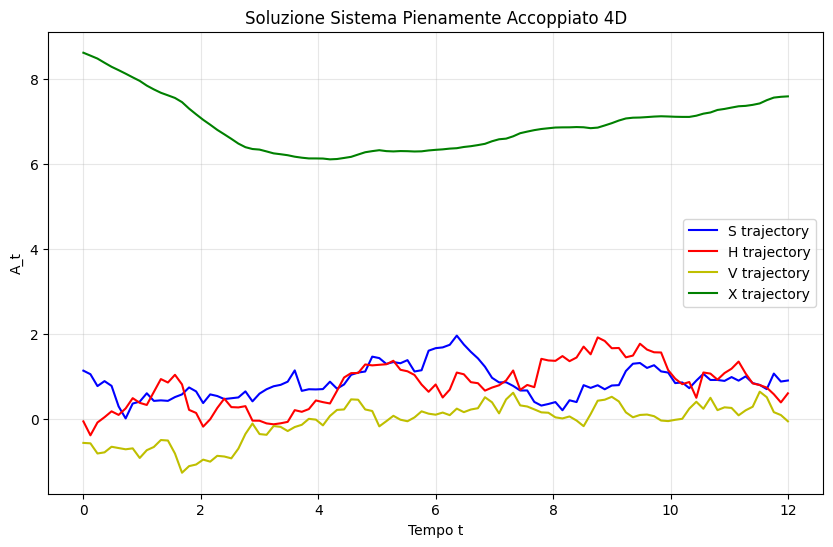

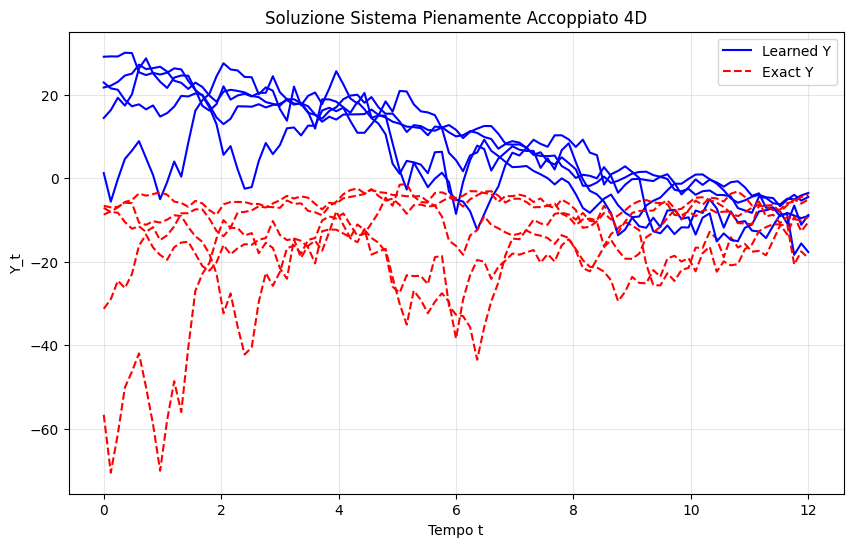

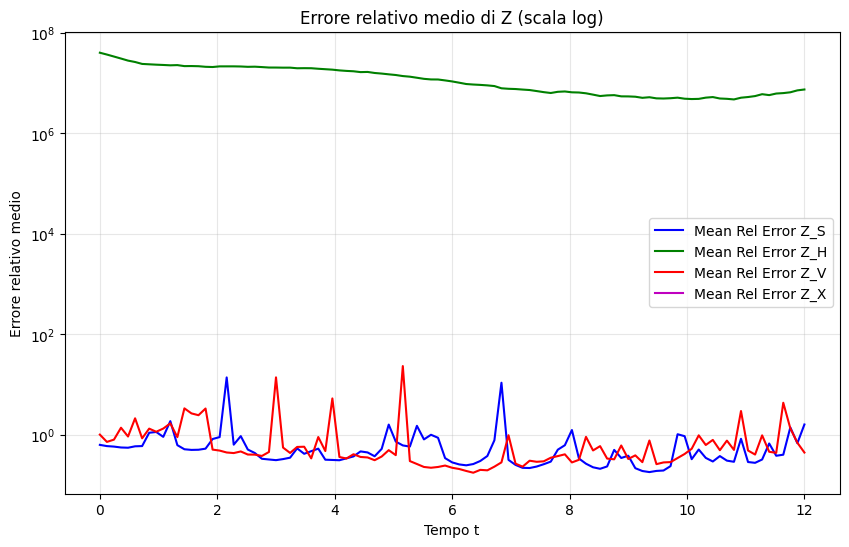

<Figure size 640x480 with 0 Axes>

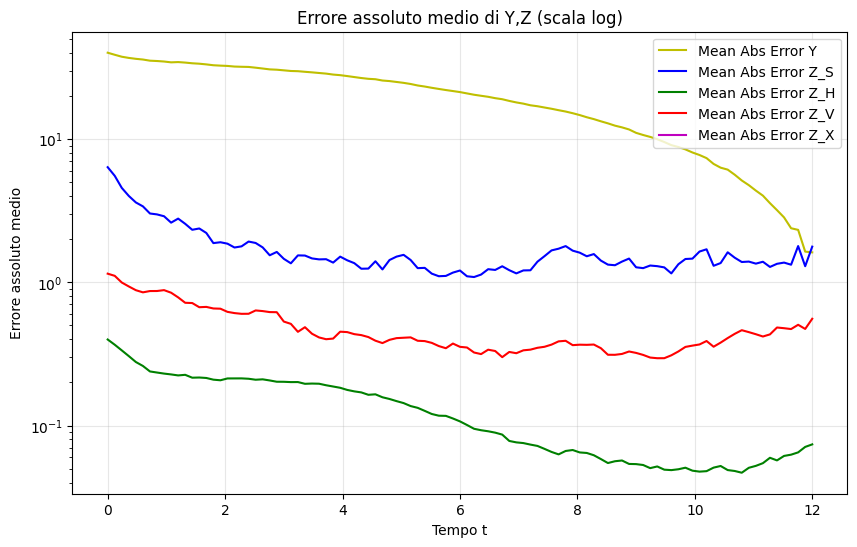

In [13]:
# --- PLOTTING ---
t_test, W_test, Xi_test = model.fetch_minibatch()
X_pred, Y_pred, Z_pred = model.predict(Xi_test, t_test, W_test)

def u_exact(t, Xi_arr):
    S = Xi_arr[:, 0:1]
    H = Xi_arr[:, 1:2]
    V = Xi_arr[:, 2:3]
    X_state = Xi_arr[:, 3:4]
    return -params['gamma'] * np.exp(S)*X_state + V**2 + V*X_state

def z_exact(t, Xi_arr):
    S = Xi_arr[:, 0:1]
    H = Xi_arr[:, 1:2]
    V = Xi_arr[:, 2:3]
    X_state = Xi_arr[:, 3:4]

    s1 = params['s1']
    s2 = params['s2']
    s3 = params['s3']

    common = np.exp(-t)
    z_s = -params['gamma'] * np.exp(S)*X_state * s1
    z_h = np.zeros_like(z_s)
    z_v = (2 * V + X_state) * s3
    z_x = np.zeros_like(z_s)

    return np.concatenate([z_s, z_h, z_v, z_x], axis=1)

Xi_reshaped = X_pred.reshape(-1, D)
t_reshaped = t_test.reshape(-1, 1)

Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, 1)
Z_exact = z_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, D)

#exact_Y0 = u_exact(np.array([[0.0]]), Xi)[0, 0]
#print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
#print(f"Exact Y0:     {exact_Y0:.4f}")

# Exact mean of u(0, X0)
u0_exact = u_exact(
    np.zeros((M,1)),
    Xi_test
)

mean_exact_Y0 = np.mean(u0_exact)
mean_pred_Y0  = np.mean(Y_pred[:,0,0])

print("\n--- Mean comparison at t=0 ---")
print(f"Mean Predicted Y0: {mean_pred_Y0:.6f}")
print(f"Mean Exact Y0:     {mean_exact_Y0:.6f}")
print(f"Absolute Error:    {abs(np.mean(u0_exact - Y_pred[:,0,0])):.6e}")


plt.figure(figsize=(10,6))
plt.plot(t_test[0,:,0], X_pred[0,:,0], 'b', label='S trajectory')
plt.plot(t_test[0,:,0], X_pred[0,:,1], 'r', label='H trajectory')
plt.plot(t_test[0,:,0], X_pred[0,:,2], 'y', label='V trajectory')
plt.plot(t_test[0,:,0], X_pred[0,:,3], 'g', label='X trajectory')
plt.title("Soluzione Sistema Pienamente Accoppiato 4D")
plt.xlabel("Tempo t")
plt.ylabel("A_t")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"quadratic_coupled_plots/unif/T_{T}_N_{N}_M_{M}_train_{stage_plan * len(coupling_levels) + final_plan}_FSDE.png")

plt.figure(figsize=(10,6))
plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
plt.plot(t_test[1:5,:,0].T, Y_pred[1:5,:,0].T, 'b')
plt.plot(t_test[1:5,:,0].T, Y_exact[1:5,:,0].T, 'r--')
plt.title("Soluzione Sistema Pienamente Accoppiato 4D")
plt.xlabel("Tempo t")
plt.ylabel("Y_t")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"quadratic_coupled_plots/unif/T_{T}_N_{N}_M_{M}_train_{stage_plan * len(coupling_levels) + final_plan}_Y.png")

# Errore relativo medio sui componenti di Z (stile log_z, ma corretto per ogni componente)
eps = 1e-8
rel_err_Z = np.abs((Z_pred - Z_exact) / (np.abs(Z_exact) + eps))
mean_rel_err_Z = np.mean(rel_err_Z, axis=0)  # (N+1, D)

labels = ['Z_S', 'Z_H', 'Z_V', 'Z_X']
colors = ['b', 'g', 'r', 'm']

plt.figure(figsize=(10,6))
for d in range(D):
    plt.plot(t_test[0,:,0], mean_rel_err_Z[:, d], colors[d], label=f'Mean Rel Error {labels[d]}')
plt.yscale('log')
plt.title('Errore relativo medio di Z (scala log)')
plt.xlabel('Tempo t')
plt.ylabel('Errore relativo medio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
plt.savefig(f"quadratic_coupled_plots/unif/T_{T}_N_{N}_M_{M}_train_{stage_plan * len(coupling_levels) + final_plan}_Z.png")

abs_err_Z = np.mean(np.abs(Z_pred - Z_exact),axis=0)
abs_err_Y = np.mean(np.abs(Y_pred - Y_exact),axis=0)
plt.figure(figsize=(10,6))
plt.plot(t_test[0,:,0], abs_err_Y[:,0],'y', label=f'Mean Abs Error Y')
for d in range(D):
    plt.plot(t_test[0,:,0], abs_err_Z[:, d], colors[d], label=f'Mean Abs Error {labels[d]}')
plt.yscale('log')
plt.title('Errore assoluto medio di Y,Z (scala log)')
plt.xlabel('Tempo t')
plt.ylabel('Errore assoluto medio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"quadratic_coupled_plots/unif/T_{T}_N_{N}_M_{M}_train_{stage_plan * len(coupling_levels) + final_plan}_abs_err.png")

In [14]:
import sys

with open(f"quadratic_coupled_plots/unif/T_{T}_N_{N}_M_{M}_train_{stage_plan * len(coupling_levels) + final_plan}.txt", "w") as f:
    original_stdout = sys.stdout
    sys.stdout = f

    print(stage_plan * len(coupling_levels))
    print(final_plan)
    print("=== Curriculum Log (compact) ===")
    tot_time = 0
    for row in stage_logs:
        tot_time += row["elapsed_sec"]
        print(
            f"phase={row['phase']}, const={row['const']:.1f}, lr={row['lr']:.1e}, iters={row['n_iter']}, "
            f"eval_loss={row['eval_mean_loss']:.3e}, eval_y0={row['eval_mean_y0']:.3f}, elapsed_sec={row['elapsed_sec']}"
        )
    print('total time=', tot_time, 's = ', tot_time/3600, 'h')

    sys.stdout = original_stdout